# Mapping Chemical Space with UMAP

[![Open in Google Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/12uTTwDvfSUKK8g5iQ9mbEgX6kJnp9B30?usp=sharing)

**Content**:
1. Create 2D visualization of Blood Brain Barrier Permeability (BBBP) dataset with UMAP
2. Compare the UMAP embedding to PCA and T-SNE embeddings
3. Embed the dataset in a chemical dataset

**The dataset**:  
The BBBP (Blood-Brain Barrier Penetration) dataset from [MoleculeNet](https://moleculenet.org/datasets-1) contains information on molecules and their ability to penetrate the blood-brain barrier, which is crucial for drug discovery and development.

**The method**:  
The UMAP method is an example of *unsupervised* machine learning since the data is processed without knowing its label.

**Methodology**:
- This notebook has gaps that you have to fill. If all gaps are filled in correctly, the notebook can be run.
- A solution notebook with all gaps filled is provided in the GitHub repository.
- Gaps are marked with a `#TODO`

This notebook has been created being inspired by or using content from [Source Notebook on Google Colab](https://colab.research.google.com/gist/ElanaPearl/444b3331f61485bbe8862db27cb2b968/mapping-chemical-space-with-umap.ipynb#scrollTo=dzmJAwfiAi6k)

### Import libraries and data
Here all necessary libraries are imported and the necessary data is fetched. Also helper functions are set up.

In [ ]:
import os

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import rdkit
import sklearn
import umap.umap_ as umap
import hdbscan

from rdkit.Chem import AllChem
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

In [2]:
# Silence non-critical RDKit warnings to minimize unnecessary outputs
lg = rdkit.RDLogger.logger()
lg.setLevel(rdkit.RDLogger.CRITICAL)

In [3]:
def get_largest_fragment_from_smiles(s: str):
    mol = rdkit.Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return rdkit.Chem.MolToSmiles(clean_mol)
    return None

def compute_ecfp_descriptors(smiles_list: List[str]):
    """ Computes ecfp descriptors """

    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = rdkit.Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = rdkit.Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)

    return None

Load data if neccesary

In [4]:
if os.path.exists('data/BBBP.csv'):
    bbbp = pd.read_csv("data/BBBP.csv")
    print("Data loaded from local file")
else:
    bbbp = pd.read_csv("https://github.com/moritzmarquardt/workshop_IBEC/raw/refs/heads/main/data/BBBP.csv")
    # save the data locally
    bbbp.to_csv("data/BBBP.csv", index=False)
    print("Data loaded from URL and saved locally")

bbbp.head()

Data loaded from local file


,num,name,p_np,smiles
0,1,Propanolol,1,[Cl].CC(C)NCC(O)COc1cccc2ccccc12
1,2,Terbutylchlorambucil,1,C(=O)(OC(C)(C)C)CCCc1ccc(cc1)N(CCCl)CCCl
2,3,40730,1,c12c3c(N4CCN(C)CC4)c(F)cc1c(c(C(O)=O)cn2C(C)CO...
3,4,24,1,C1CCN(CC1)Cc1cccc(c1)OCCCNC(=O)C
4,5,cloxacillin,1,Cc1onc(c2ccccc2Cl)c1C(=O)N[C@H]3[C@H]4SC(C)(C)...


In [5]:
if os.path.exists('data/chembl_sparse.csv.gz'):
    chembl = pd.read_csv("data/chembl_sparse.csv.gz", compression='gzip')
    print("Data loaded from local file")
else:
    # Read in data from MoleculeNet
    chembl = pd.read_csv(
        "https://github.com/moritzmarquardt/workshop_IBEC/raw/refs/heads/main/data/chembl_sparse.csv.gz", 
        compression='gzip'
        )
    # save the data locally
    chembl.to_csv("data/chembl_sparse.csv.gz", index=False, compression='gzip')
    print("Data loaded from URL and saved locally")

chembl.head()

Data loaded from local file


,smiles,CHEMBL1075051,CHEMBL1075104,CHEMBL1075145,CHEMBL1075189,CHEMBL1075228,CHEMBL1075284,CHEMBL1075319,CHEMBL1163101,CHEMBL1163116,...,CHEMBL6084,CHEMBL6136,CHEMBL6137,CHEMBL6140,CHEMBL6141,CHEMBL6145,CHEMBL6154,CHEMBL6164,CHEMBL6166,CHEMBL6184
0,Oc1ccccc1\C=N\c2ccccc2\N=C\c3ccccc3O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,C[C@@H](O)[C@H](NC(=O)CN(CCCNC(=N)N)NC(=O)[C@H...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Oc1cnc2[nH]c3cnc(cc3c2c1)C#N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,COc1c(C)c2COC(=O)c2c(O)c1CCOP(=O)(O)CCSc3nc4c(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,C[C@H]1CN(CCCN(c2ccccc2)c3ccccc3)C[C@H](C)N1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Embed BBBP with UMAP, PCA, t-SNE (Dataset-Specific Embeddings)

### Read in and process data

In [6]:
# Clean up columnn names so they are easier to interpret
bbbp = bbbp[["smiles", "p_np", "name"]].reset_index(drop=True).rename({"p_np": "permeable"}, axis=1)

# Remove extra fragments in SMILES (typically salts, which are irrelevant to BBB permeability)
bbbp["smiles"] = bbbp["smiles"].apply(get_largest_fragment_from_smiles).dropna()
pd.DataFrame(bbbp).head()

,smiles,permeable,name
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin


### Compute ECFP Descriptors
 embed your smiles as [ECFPs](https://pubs.acs.org/doi/10.1021/ci100050t)

In [7]:
# Compute desrciptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Only keep those that sucessfully featurized
bbbp = bbbp.iloc[keep_idx]

### Embed with UMAP

In [8]:
%%time
umap_reducer = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
umap_embedding = umap_reducer.fit_transform(ecfp_descriptors)
bbbp["UMAP_0"], bbbp["UMAP_1"] = umap_embedding[:,0], umap_embedding[:,1]
pd.DataFrame(bbbp).head()

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


CPU times: total: 30.3 s
Wall time: 31.8 s


,smiles,permeable,name,UMAP_0,UMAP_1
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,12.205689,12.660856
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,11.850484,12.045847
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,11.672757,7.419153
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,12.795776,8.856261
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,5.925620,3.231515


### Embed with PCA

In [9]:
%%time
pca = sklearn.decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors)
bbbp["PCA_0"], bbbp["PCA_1"] = X_pca[:,0], X_pca[:,1]
pd.DataFrame(bbbp).head()

CPU times: total: 453 ms
Wall time: 104 ms


,smiles,permeable,name,UMAP_0,UMAP_1,PCA_0,PCA_1
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,12.205689,12.660856,-0.884475,0.820319
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,11.850484,12.045847,-0.141916,0.399113
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,11.672757,7.419153,0.196499,-0.384078
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,12.795776,8.856261,-0.607427,-0.263522
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,5.925620,3.231515,0.121065,1.925423


### Embed with t-SNE

In [10]:
%%time
tsne = sklearn.manifold.TSNE(n_components=2)
X_tsne = tsne.fit_transform(ecfp_descriptors)
bbbp["TNSE_0"], bbbp["TNSE_1"] = X_tsne[:,0], X_tsne[:,1]
pd.DataFrame(bbbp).head()

CPU times: total: 1min 1s
Wall time: 8.38 s


,smiles,permeable,name,UMAP_0,UMAP_1,PCA_0,PCA_1,TNSE_0,TNSE_1
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,12.205689,12.660856,-0.884475,0.820319,-25.724493,14.682714
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,11.850484,12.045847,-0.141916,0.399113,-31.696430,-2.474245
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,11.672757,7.419153,0.196499,-0.384078,-37.601742,-32.599449
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,12.795776,8.856261,-0.607427,-0.263522,-37.102863,37.957840
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,5.925620,3.231515,0.121065,1.925423,-64.114578,10.929878


### Visualize the dataset embeddedings

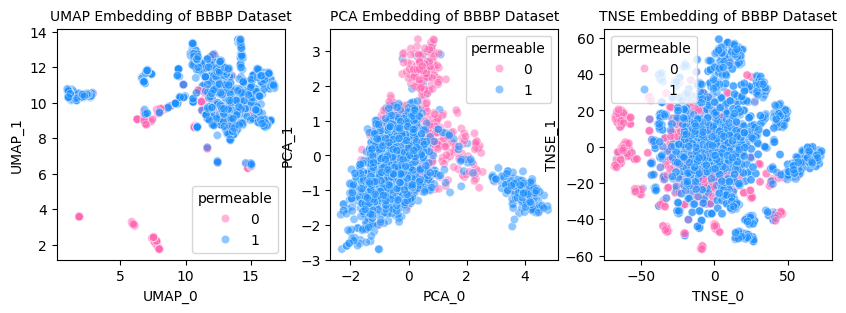

In [11]:
palette = sns.color_palette(["hotpink", "dodgerblue"])
fig, ax = plt.subplots(1, 3, figsize=(10,3))
for i, method in enumerate(["UMAP", "PCA", "TNSE"]):
    sns.scatterplot(data=bbbp,
                    x=f"{method}_0",
                    y=f"{method}_1",
                    hue="permeable",
                    alpha=0.5,
                    palette=palette,
                    ax=ax[i])
    ax[i].set_title(f"{method} Embedding of BBBP Dataset", fontsize=10)

## Embedding in global Chem dataset

In [12]:
# Sample a random 10k
chembl_sample = chembl.sample(n=10000)

pd.DataFrame(chembl_sample).head()

,smiles,CHEMBL1075051,CHEMBL1075104,CHEMBL1075145,CHEMBL1075189,CHEMBL1075228,CHEMBL1075284,CHEMBL1075319,CHEMBL1163101,CHEMBL1163116,...,CHEMBL6084,CHEMBL6136,CHEMBL6137,CHEMBL6140,CHEMBL6141,CHEMBL6145,CHEMBL6154,CHEMBL6164,CHEMBL6166,CHEMBL6184
228827,CC(C(=O)NCc1ccc(cc1SCc2occc2)C(F)(F)F)c3ccc(NS...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
68915,COc1ncc(cc1c2ccc(cc2[C@@H]3CC[C@H]4[C@H](OC(=O...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
163392,Fc1ccc(cc1OCC2CC2)[C@H](NS(=O)(=O)CCCOCN3C=CC(...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33994,C[C@@H]1N2[C@H](Cc3c1[nH]c4cc5ccccc5cc34)C(=O)...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
170779,CC(C)[C@H](NC(=O)[C@@H]1CSSC[C@H](NC(=O)[C@@H]...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
%%time
# Compute desrciptors and keep track of which failed to featurize
chembl_ecfp_descriptors, chembl_keep_idx = compute_ecfp_descriptors(chembl_sample["smiles"])

# Only keep those that sucessfully featurized
chembl_sample = chembl_sample.iloc[chembl_keep_idx]

CPU times: total: 13.7 s
Wall time: 14.4 s


In [14]:
%%time
umap_model_global = umap.UMAP(metric = "jaccard",
                               n_neighbors = 25,
                               n_components = 2,
                               low_memory = False,
                               min_dist = 0.001)
X_umap_global = umap_model_global.fit_transform(chembl_ecfp_descriptors)
chembl_sample["UMAP_0"], chembl_sample["UMAP_1"] = X_umap_global[:,0], X_umap_global[:,1]

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\umap\umap_.py:1887: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


CPU times: total: 1min 13s
Wall time: 24.3 s


In [15]:
%%time
X_umap_bbbp = umap_model_global.transform(ecfp_descriptors)
bbbp["UMAP_0 (global)"], bbbp["UMAP_1 (global)"] = X_umap_bbbp[:,0], X_umap_bbbp[:,1]

c:\Users\marqu\SynologyDrive\Drive\Aktivitäten\FORSCHUNG\Talk IBEC Barcelona\workshop_py\.venv\lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


CPU times: total: 21.7 s
Wall time: 20.1 s


In [16]:
pd.DataFrame(bbbp).head()

,smiles,permeable,name,UMAP_0,UMAP_1,PCA_0,PCA_1,TNSE_0,TNSE_1,UMAP_0 (global),UMAP_1 (global)
0,CC(C)NCC(O)COc1cccc2ccccc12,1,Propanolol,12.205689,12.660856,-0.884475,0.820319,-25.724493,14.682714,10.721007,4.222404
1,CC(C)(C)OC(=O)CCCc1ccc(N(CCCl)CCCl)cc1,1,Terbutylchlorambucil,11.850484,12.045847,-0.141916,0.399113,-31.696430,-2.474245,11.192494,3.310003
2,CC1COc2c(N3CCN(C)CC3)c(F)cc3c(=O)c(C(=O)O)cn1c23,1,40730,11.672757,7.419153,0.196499,-0.384078,-37.601742,-32.599449,7.980077,2.574866
3,CC(=O)NCCCOc1cccc(CN2CCCCC2)c1,1,24,12.795776,8.856261,-0.607427,-0.263522,-37.102863,37.957840,11.703223,5.244720
4,Cc1onc(-c2ccccc2Cl)c1C(=O)N[C@@H]1C(=O)N2[C@@H...,1,cloxacillin,5.925620,3.231515,0.121065,1.925423,-64.114578,10.929878,9.358148,3.176914


Text(0.5, 1.0, 'Global UMAP Embedding of BBBP Dataset')

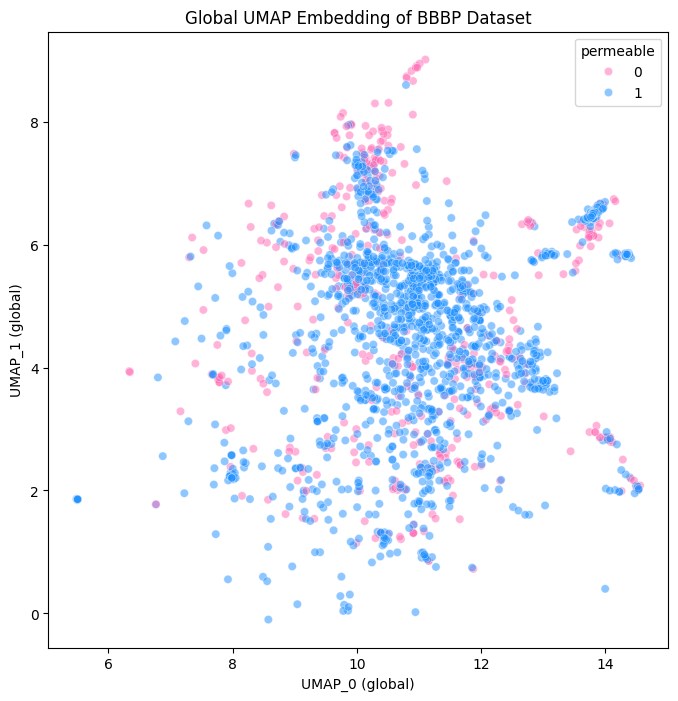

In [17]:
# visualise global umap from bbbp
plt.figure(figsize=(8,8))
sns.scatterplot(data=bbbp,
                x="UMAP_0 (global)",
                y="UMAP_1 (global)",
                hue="permeable",
                alpha=0.5,
                palette=palette)
plt.title("Global UMAP Embedding of BBBP Dataset")
